Ce notebook est une première tentative de création d'un modèle inspiré de celui de Spelter et Nirschel dont la référence est la suivante :

Spelter, L.E., Nirschl, H., Stickland, A.D. and Scales, P.J. (2013), Pseudo two‐dimensional modeling of sediment build‐up in centrifuges: A compartment approach using compressional rheology. AIChE J., 59: 3843-3855. doi:10.1002/aic.14115

Tout repose sur l'observation d'une couche limite qui se situe à la surface de l'anneau liquide (côté air). Cette couche limite se caractérise par la présence d'importantes vitesses axiales ascendantes. En dehors de cette couche, les vitesse axiales sont au moins d'un ordre de grandeur inférieures. On peut donc légitimement considérer que seule la décantation centrifuge agit en dehors de la couche limite. La largeur de cette couche limite est variable. Celle-ci dépend de nombreux paramêtres opératoires et géométriques. 

<div>
<img src="bl_schemes.png" width="400"/>
</div>

De même, la vitesse axiale qui y est observée n'est pas une constante. Celle-ci est à la fois fonction des positions radiale et axiale. Cette distribution de la vitesse est en partie responsable des différences de comportement de particules de même diamètre.

<div>
<img src="meshless.png" width="800"/>
</div>

<div>
<img src="bl_profile.png" width="400"/>
</div>

Sans reprendre le cheminement suivit par l'auteur, intéressons nous directement à la fonction qui permet de prévoir la hauteur à laquelle une particule d'un dimètre donné quitte la couche limite pour entrer dans la couche de décantation.

$$
\begin{align}
\large{z = \frac{ln\left(\frac{r_{boundary}}{r_{weir}}\right) . 18 . \mu . v}{\Delta \rho . x^{2} . \left( \frac{2.\pi.n}{60} \right)^{2}}}
\end{align}
$$

$r_{boundary}$ est le rayon auquel se trouve la limite de la couche limite.

$r_{weir}$ est le rayon auquel se trouve le débordement.

$\mu$ est la viscosité dynamique du liquide 

$\Delta \rho$ l'écart de masse volumique entre solide et liquide.

$z$ est, entre autres, fonction de la vitesse axiale locale dans la couche limite et du diamètre $x$ de la particule. Si $z$ est supérieur à la hauteur du bol, on considère que la particule est sortie. 

Pour initier l'étude, commençons par ne considérer qu'une classe de particules de diamètre $1µm$ et de masse volumique $2650Kg/m^{3}$. Pour les vitesses axiales, prenons les profils de Romani, présentés dans sa publication de 2009 dont un aperçu est donné à la figure suivante:

<div>
<img src="romani_profiles.png" width="400"/>
</div>

En guise d'exemple prenons le profil extrait à $z=0,2m$. Pour disposer de toutes les vitesses nécessaires en fonction du rayon r, un fit de la courbe est réalisé.

[-971.55284767  270.03060522  -17.08602866]


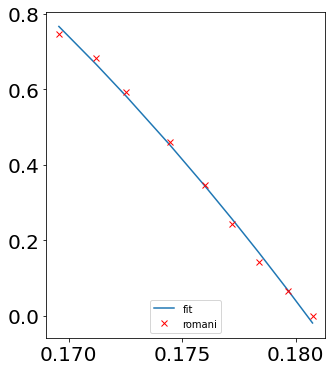

[ 0.76693704  0.66776109  0.58215698  0.45336179  0.34465839  0.25596731
  0.16867644  0.06793541 -0.01859661]


In [47]:
import scipy.optimize
import numpy as np
from numpy import genfromtxt
from scipy.stats import halfnorm, truncnorm
import matplotlib.pyplot as plt

def parabola(x, a, b, c):
    return a*x**2 + b*x + c

my_data = genfromtxt('z02.csv', delimiter=',')

x = my_data[:,0]
y = my_data[:,1]

fit_params, pcov = scipy.optimize.curve_fit(parabola, x, y)
print(fit_params)
y_fit = parabola(x, *fit_params)


plt.figure(figsize=(5,6))
plt.plot(x, y_fit, label='fit')
plt.plot(x, y, 'xr', label='romani')  
plt.legend(loc='lower center')  
plt.show()
print(y_fit)

Sur les 10mm de largeur de la couche limite, Uz est donc donné par la relation suivante:

$$
\begin{align}
\large{U_{z} = -971r^{2} + 270r -17}
\end{align}
$$

Considérons maintenant qu'un nombre donné de particules se trouvent dans la couche limite et que ces particules sont uniformément réparties. notons R l'ensemble des positions radiales de ces particules.

In [2]:
R = np.sort(np.random.uniform(0.17,0.18,2000))

Traçons maintenant $z$ en fonction de $r$ en injectant $U_{z}$ dans l'expression de $z$. Ce qui donne :

$$
\begin{align}
\large{z = \frac{ln\left(\frac{r_{boundary}}{r_{weir}}\right) . 18 . \mu . \left( -971 r^{2} + 270 r - 17\right)}{\Delta \rho . x^{2} . \left( \frac{2.\pi.n}{60} \right)^{2}}}
\end{align}
$$

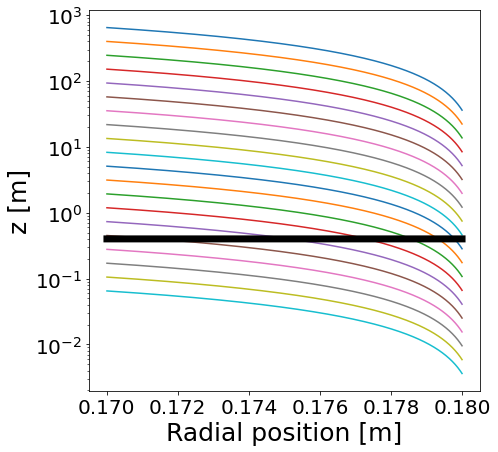

In [3]:
omega_rpm = 2550
omega = 2 * np.pi / 60 * omega_rpm

def z(r, r_boundary, r_weir, mu, delta_rho, x, omega):
    return ((np.log(r_boundary/r_weir) * 18 * mu * parabola(r, *fit_params)) / (delta_rho * x**2 * omega**2))

diameters = np.logspace(-7, -5, num=20)
#diameters = [3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 1e-06, 2e-06, 3e-06, 4e-06, 5e-06, 6e-06, 7e-06, 8e-06, 9e-06, 1e-05]


import matplotlib     

matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)



plt.figure(figsize=(7,7))


for x in diameters:
    settling_h = z(R, 0.18, 0.17, 0.001, 1650, x, omega)
    plt.plot(R, settling_h, label=str(x) + ' micron')
    
plt.plot(R, 0.4*np.ones(len(R)), 'k', label='Bowl height', linewidth=7.0)
plt.yscale('log')
plt.xlabel('Radial position [m]', fontsize=25)
plt.ylabel('z [m]', fontsize=25)
#plt.legend()  
plt.show()



Voyons maintenant ce que cela donne en termes de g(x). Il suffit pour cela de compter le nombre de particule de chaque classe dont z est inférieur à 0,4m.

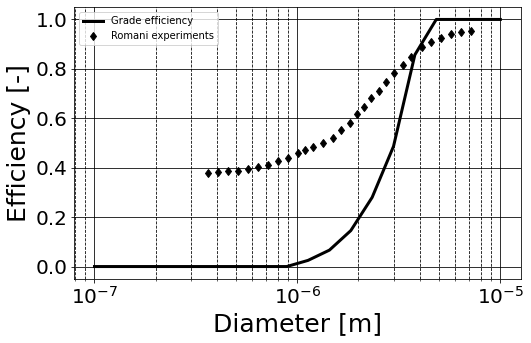

In [5]:
romani_data = genfromtxt('romani_gx.csv', delimiter=',')

g_x = np.zeros((len(diameters),2))
i = 0

for x in diameters:
    settling_h = z(R, 0.18, 0.17, 0.001, 1650, x, omega)
    g_x[i,1] = (sum(settling_h<0.4)/len(R))
    g_x[i,0] = x
    i += 1
    
plt.figure(figsize=(8,5))
plt.plot(diameters, g_x[:,1], 'k', label='Grade efficiency', linewidth=3.0)
plt.plot(romani_data[:,0]*1e-06, romani_data[:,1], 'dk', label='Romani experiments')
#plt.grid(True)
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
plt.xscale('log')
plt.xlabel('Diameter [m]', fontsize=25)
plt.ylabel('Efficiency [-]', fontsize=25)
plt.legend()  
plt.show()

Le modèle sous-estime considérablement l'arrêt des fines et la perte des grands diamètres. Deux leviers pourraient être "actionnés" pour ajuster le g(x) modélisé:

<ul>
<li>le profil de vitesse axiale</li>
<li>la répartition radiale des particules au départ.</li>
<li>la prise en compte des fluctuations turbulentes de vitesse</li>
</ul>

Le profil de vitesse axiale est néanmoins assez proche de la réalité et le manque d'une dépendance à $z$ ne suffit pas à justifier l'écart avec lexpérimental. La prise en compte des fluctuations peut introduire des variations aléatoire de l'ordre de 10% de la vitesse axiale actuelle. L'effet final sur l'ensemble des particules de même diamètre est à priori difficile à anticiper. Cette contribution sera testée en dernier recours. 

Pour ce premier test, les particules d'un même diamètre ont été uniformément réparties le long de la largeur de la couche limite. Rien ne permet d'affirmer que les particules sont réparties de cette manière. La modification de cette répartition initiale des particules peut avoir une incidence sur les g(x). Supposons par exemple que les particules soient initialement plus proches de l'interface air-eau que de la frontière de la couche limite. Dans ce premier cas, cela devrait se traduire par une augmentation de fuites; les particules ayant plus de temps pour suivre le flux axial. Inversement si les particules sont plutôt majoritairement positionnées près de la frontière de la couche limite, cela se traduira par un taux de capture plus élevé.

La modification de la répartition peut se faire en utilisant une loi normale pour $R$ en jouant sur la valeur du rayon central pour se placer plutôt à gauche ou plutôt à droite. Cette modification peut être faite pour chaque classe de particule car rien ne justifie le fait que toutes les classes aient une répartition spatiale identique.

In [110]:
R_uni = np.sort(np.random.uniform(0.17,0.18,2000))
#R_left = halfnorm.rvs(loc=0.17, scale=0.002,size=2000)
#R_temp = halfnorm.rvs(loc=0.18, scale=0.002,size=2000)
#R_right = [((2*0.18)-k) for k in R_temp]

lower, upper = 0.17, 0.18
sigma = 0.002

def myTruncatedNormal(lower, upper, mu, sigma, population):
    X = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    R_random = X.rvs(population)
    return R_random

R_random = myTruncatedNormal(lower, upper, 0.173, sigma, 2000)
R_left = myTruncatedNormal(lower, upper, 0.17, sigma, 2000)
R_right = myTruncatedNormal(lower, upper, 0.18, sigma, 2000)

## Remarque:
L'utilisation de truncnorm permet de maîtriser le nombre de positions générées. Ceci permet un décompte conforme à la distribution initialement injectée dans la centrifugeuse.

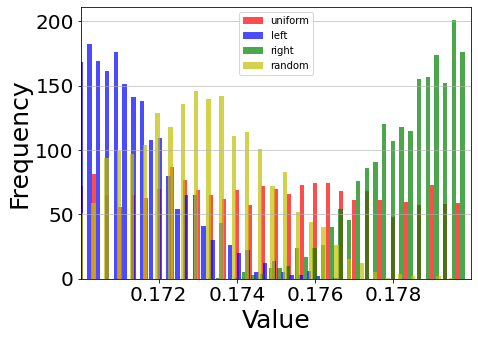

In [111]:
hist_uni,bin_edges_uni = np.histogram(R_uni, bins=30)
hist_l,bin_edges_l = np.histogram(R_left, bins=30)
hist_r,bin_edges_r = np.histogram(R_right, bins=30)
hist_ra,bin_edges_ra = np.histogram(R_random, bins=30)

plt.figure(figsize=[7,5])

plt.bar(bin_edges_uni[:-1], hist_uni, width = ((bin_edges_l[1]-bin_edges_l[0])/2), color='r',alpha=0.7, label='uniform')
plt.bar(bin_edges_l[:-1], hist_l, width = ((bin_edges_l[1]-bin_edges_l[0])/2), color='b',alpha=0.7, label='left')
plt.bar(bin_edges_r[:-1], hist_r, width = ((bin_edges_l[1]-bin_edges_l[0])/2), color='g',alpha=0.7, label='right')
plt.bar(bin_edges_ra[:-1], hist_ra, width = ((bin_edges_l[1]-bin_edges_l[0])/2), color='y',alpha=0.7, label='random')


plt.xlim(min(bin_edges_uni), max(bin_edges_uni))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=25)
plt.ylabel('Frequency',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('Normal Distribution Histogram',fontsize=25)
plt.legend()  
plt.show()